## Some image processing for Computer Vision


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # activation function
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(degrees=15),   # Randomly rotate the image by up to ±15 degrees
    transforms.ToTensor(),                   # Convert the image to a PyTorch tensor and scale pixel values to [0, 1]
    transforms.Normalize((0.5,), (0.5,))     # Normalize the tensor to have values in range [-1, 1]
])


In [3]:
# Define transformations for the test set (without data augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)) # Normalize the data to [-1, 1]
])

In [4]:
# Download and load the training data with augmentation

trainset = torchvision.datasets.FashionMNIST(
    root = './data',
    train = True,
    download = True,
    transform = train_transforms

)

testset = torchvision.datasets.FashionMNIST(
      root = './data',
      train = False,
      download = True,
      transform = test_transforms

)

100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.82MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 64.6MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.5MB/s]


In [5]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = 64,
    shuffle = True
)


testloader = torch.utils.data.DataLoader(
    testset,
    batch_size = 64,
    shuffle = False
)

Augmented Image : 


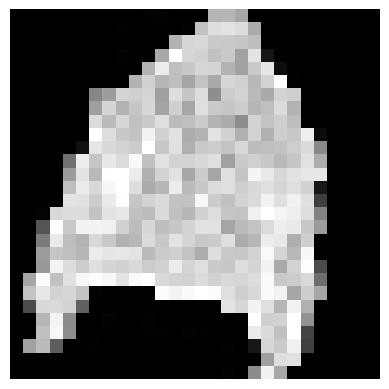

Label :  Shirt
Original Images : 


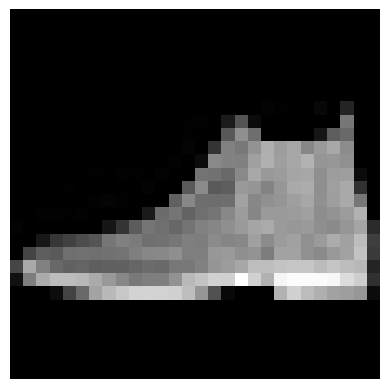

Label :  Ankle boot


In [6]:
# 2. Understanding the Data
# Map numeric labels to class names

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Function to show an image

def imshow(img):
  img = img / 2 + 0.5 # Unnormalize the image
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)).squeeze(), cmap='gray')
  plt.axis('off')
  plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show one augmented image

print('Augmented Image : ')
imshow(images[0])
print('Label : ', classes[labels[0]])

# Get some random test images (without augmentation )

test_dataiter = iter(testloader)
test_images, test_labels = next(test_dataiter)


print('Original Images : ')
imshow(test_images[0])
print('Label : ', classes[test_labels[0]])


Batch of Augmented Images:


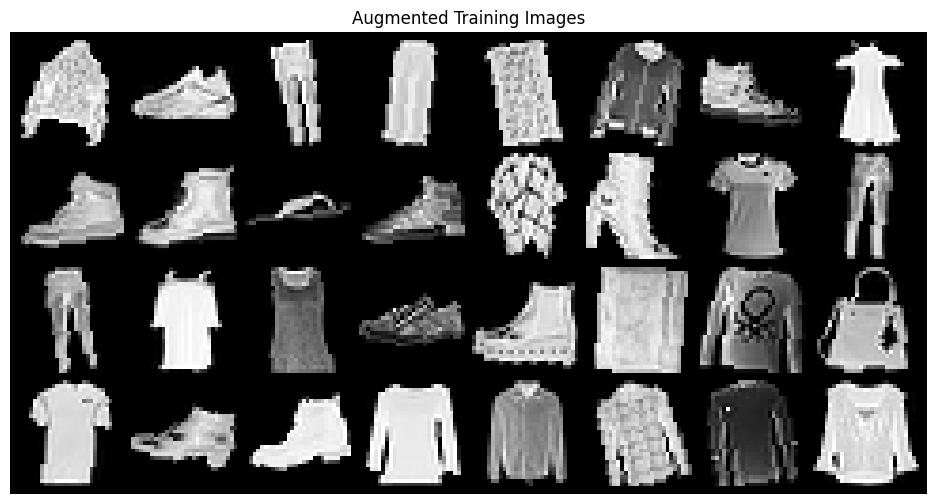

Labels: Shirt Sneaker Trouser Trouser Shirt Coat Sneaker Dress Sneaker Ankle boot Sandal Sneaker Coat Ankle boot T-shirt/top Trouser Trouser Dress T-shirt/top Sneaker Ankle boot Bag Pullover Bag T-shirt/top Ankle boot Ankle boot T-shirt/top Coat Shirt Pullover Shirt
Batch of Original Test Images:


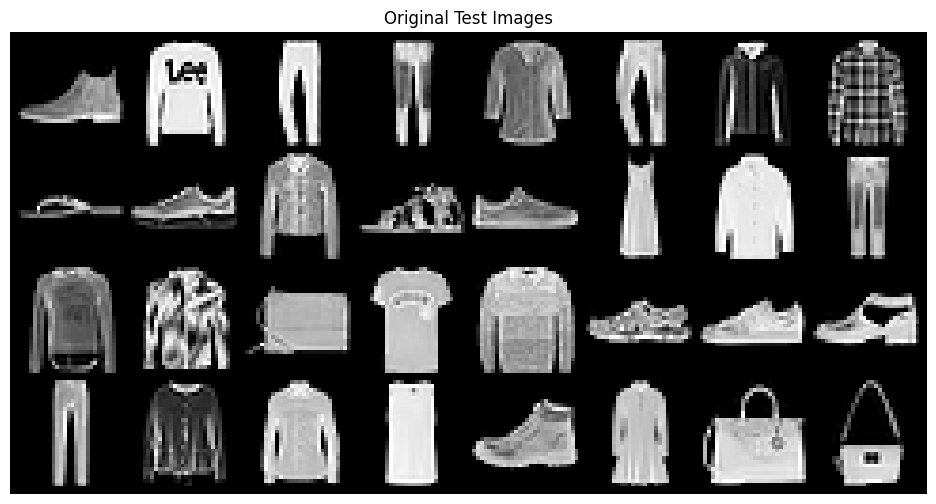

Labels: Ankle boot Pullover Trouser Trouser Shirt Trouser Coat Shirt Sandal Sneaker Coat Sandal Sneaker Dress Coat Trouser Pullover Coat Bag T-shirt/top Pullover Sandal Sneaker Ankle boot Trouser Coat Shirt T-shirt/top Ankle boot Dress Bag Bag


In [7]:
# 3. Visualizing Augmented Images

# Function to display a batch of images
def imshow_batch(img_batch, labels_batch, title):
    img_batch = img_batch / 2 + 0.5                      # Unnormalize images from [-1, 1] to [0, 1]
    npimg = torchvision.utils.make_grid(img_batch, nrow=8)  # Create a grid of images (8 per row)
    npimg = npimg.numpy()                               # Convert tensor to NumPy array
    plt.figure(figsize=(12, 6))                         # Set figure size for better visibility
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze()) # Rearrange dimensions to (H, W, C) for plotting
    plt.title(title)
    plt.axis('off')
    plt.show()
    print('Labels:', ' '.join(f'{classes[labels_batch[j]]}'  # Print the class names for each image
                              for j in range(len(labels_batch))))

# Display a batch of augmented images
print('Batch of Augmented Images:')
imshow_batch(images[:32], labels[:32], 'Augmented Training Images')  # Show first 32 augmented images

# Display a batch of original test images
print('Batch of Original Test Images:')
imshow_batch(test_images[:32], test_labels[:32], 'Original Test Images')  # Show first 32 test images



In [8]:
# Define a CNN architecture
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()                        # Call the parent class constructor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Conv layer 1: 1→32 channels
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)          # Conv layer 2: 32→64 channels
        self.pool = nn.MaxPool2d(2, 2)                        # Max pooling with 2x2 kernel and stride 2
        self.dropout_conv = nn.Dropout2d(0.25)                # 25% dropout after conv layers
        self.dropout_fc = nn.Dropout(0.5)                     # 50% dropout after fully connected layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128)                 # Fully connected layer: flatten→128
        self.fc2 = nn.Linear(128, 10)                         # Output layer: 128→10 (number of classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))                             # Apply ReLU to conv1 output
        x = self.pool(x)                                      # Apply max pooling → [B, 32, 14, 14]
        x = F.relu(self.conv2(x))                             # Apply ReLU to conv2 output
        x = self.pool(x)                                      # Apply max pooling → [B, 64, 7, 7]
        x = self.dropout_conv(x)                              # Apply dropout after conv layers
        x = x.view(-1, 64 * 7 * 7)                             # Flatten the tensor for FC layers
        x = F.relu(self.fc1(x))                               # FC layer 1 with ReLU activation
        x = self.dropout_fc(x)                                # Apply dropout after FC layer
        x = self.fc2(x)                                       # Final output layer (logits)
        return x                                              # Return the output

# Initialize the CNN model
net = CNNNet()                                                # Create an instance of the CNN model

# 5. Choosing Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()                             # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(net.parameters(),                      # Adam optimizer for training
                       lr=0.001,                              # Learning rate
                       weight_decay=0.001)                    # L2 regularization to prevent overfitting



In [10]:

# 6. Training Parameters and Variables

num_epochs = 5  # Number of epochs to train the model
train_losses = []  # List to store training losses for each epoch
val_losses = []  # List to store validation losses for each epoch
best_val_loss = float('inf')  # Initialize best validation loss to infinity
patience = 3  # Number of epochs to wait for improvement in validation loss before stopping
trigger_times = 0  # Counter to track epochs with no improvement in validation loss

# 7. Training Loop with Early Stopping

for epoch in range(num_epochs):  # Loop through the specified number of epochs
    net.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss for the epoch
    for inputs, labels in trainloader:  # Loop through the training data
        optimizer.zero_grad()  # Reset gradients to zero
        outputs = net(inputs)  # Perform forward pass through the network
        loss = criterion(outputs, labels)  # Calculate loss between predictions and true labels
        loss.backward()  # Perform backward pass to compute gradients
        optimizer.step()  # Update model parameters based on gradients
        running_train_loss += loss.item()  # Accumulate training loss for the batch
    train_loss = running_train_loss / len(trainloader)  # Compute average training loss for the epoch
    train_losses.append(train_loss)  # Append training loss to the list

    net.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss for the epoch
    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in testloader:  # Loop through the validation data
            outputs = net(inputs)  # Perform forward pass through the network
            loss = criterion(outputs, labels)  # Calculate loss between predictions and true labels
            running_val_loss += loss.item()  # Accumulate validation loss for the batch
    val_loss = running_val_loss / len(testloader)  # Compute average validation loss for the epoch
    val_losses.append(val_loss)  # Append validation loss to the list

    # Print the training and validation losses for the current epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:  # Check if validation loss improved
        best_val_loss = val_loss  # Update best validation loss
        trigger_times = 0  # Reset trigger counter
        # Save the model checkpoint with the best validation loss
        torch.save(net.state_dict(), 'best_model.pth')  # Save model state to a file
    else:
        trigger_times += 1  # Increment trigger counter
        if trigger_times >= patience:  # Check if patience limit is reached
            print('Early stopping!')  # Notify early stopping
            break  # Exit the training loop

Epoch [1/5], Training Loss: 0.6981, Validation Loss: 0.4441
Epoch [2/5], Training Loss: 0.5216, Validation Loss: 0.3826
Epoch [3/5], Training Loss: 0.4742, Validation Loss: 0.3504
Epoch [4/5], Training Loss: 0.4439, Validation Loss: 0.3412
Epoch [5/5], Training Loss: 0.4248, Validation Loss: 0.3225


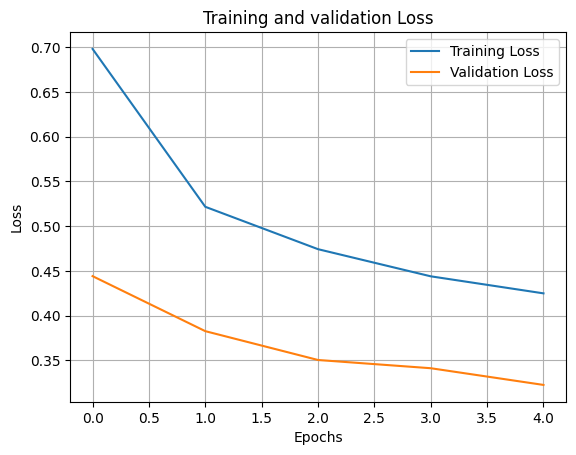

In [11]:
# Load the best Model
net.load_state_dict(torch.load('best_model.pth'))

# [;pttomg the losses
plt.figure()
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation Loss')

plt.legend()
plt.grid(True)
plt.show()

In [12]:
def evaluate_network():  # Function to evaluate the model's performance
    net.eval()  # Set the model to evaluation mode (disables dropout and other training-specific layers)
    correct = 0  # Initialize overall correct predictions counter
    total = 0  # Initialize overall total samples counter
    class_correct = [0] * 10  # Initialize per-class correct predictions counter (for 10 classes)
    class_total = [0] * 10  # Initialize per-class total samples counter (for 10 classes)

    with torch.no_grad():  # Disable gradient computation (saves memory and computation during evaluation)
        for inputs, labels in testloader:  # Loop through the test dataset
            outputs = net(inputs)  # Perform forward pass through the network
            _, predicted = torch.max(outputs, 1)  # Get the predicted class index for each sample
            total += labels.size(0)  # Increment the total sample count
            correct += (predicted == labels).sum().item()  # Increment the count of correct predictions

            # Per-class accuracy calculation
            c = (predicted == labels).squeeze()  # Get boolean tensor of correct predictions
            for i in range(len(labels)):  # Loop through each sample in the batch
                label = labels[i]  # Get the true label of the sample
                class_correct[label] += c[i].item()  # Increment correct predictions for this class
                class_total[label] += 1  # Increment total samples for this class

    # Print overall accuracy
    print(f'Overall Accuracy on the test set: {100 * correct / total:.2f}%\n')

    # Print accuracy for each class
    for i in range(10):  # Loop through each class (assuming 10 classes)
        if class_total[i] > 0:  # Check if there were any samples for this class
            print(f'Accuracy of {classes[i]:>10s}: {100 * class_correct[i] / class_total[i]:.2f}%')
        else:  # If no samples were present for this class
            print(f'Accuracy of {classes[i]:>10s}: N/A (no samples)')

# Call the evaluation function
evaluate_network()  # Evaluate the network and print results

Overall Accuracy on the test set: 88.03%

Accuracy of T-shirt/top: 85.70%
Accuracy of    Trouser: 96.80%
Accuracy of   Pullover: 78.70%
Accuracy of      Dress: 90.80%
Accuracy of       Coat: 88.40%
Accuracy of     Sandal: 92.90%
Accuracy of      Shirt: 57.70%
Accuracy of    Sneaker: 97.60%
Accuracy of        Bag: 96.90%
Accuracy of Ankle boot: 94.80%


Augmented Image:


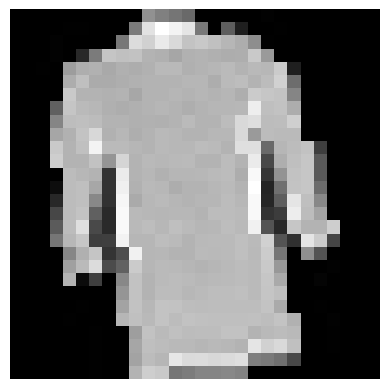

Label: T-shirt/top
Original Test Image:


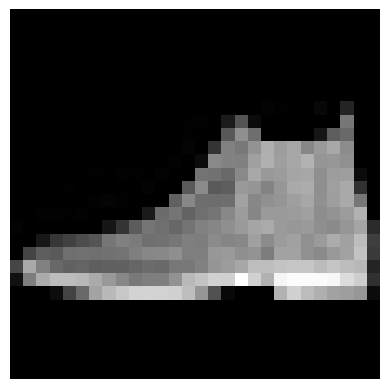

Label: Ankle boot
Batch of Augmented Images:


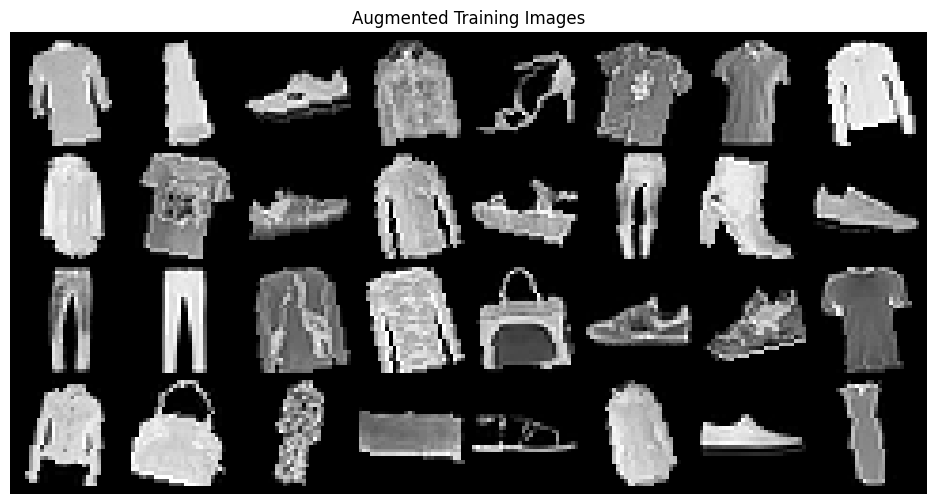

Labels: T-shirt/top Dress Sneaker Coat Sandal T-shirt/top T-shirt/top Coat Coat T-shirt/top Sneaker Shirt Sandal Trouser Ankle boot Sneaker Trouser Trouser Pullover Pullover Bag Sneaker Sneaker T-shirt/top Coat Bag Coat Bag Sandal Coat Sneaker Dress
Batch of Original Test Images:


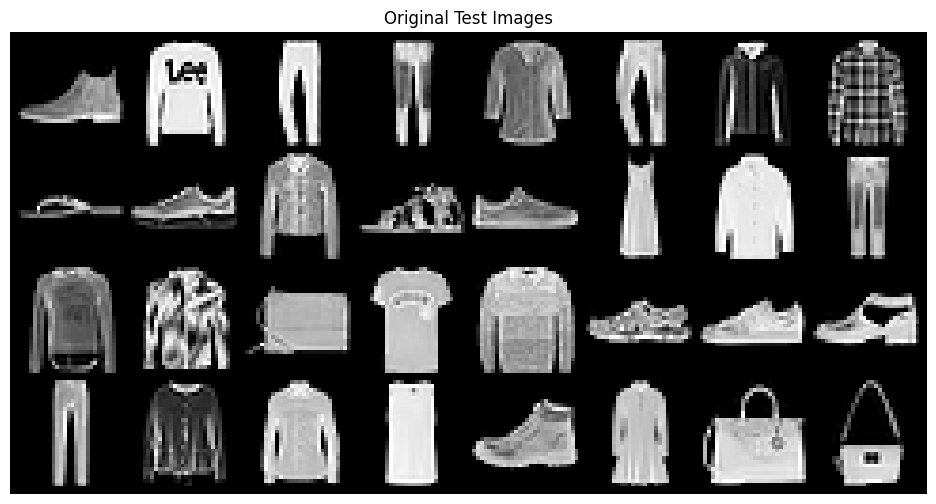

Labels: Ankle boot Pullover Trouser Trouser Shirt Trouser Coat Shirt Sandal Sneaker Coat Sandal Sneaker Dress Coat Trouser Pullover Coat Bag T-shirt/top Pullover Sandal Sneaker Ankle boot Trouser Coat Shirt T-shirt/top Ankle boot Dress Bag Bag
Epoch [1/5], Training Loss: 0.5442, Validation Loss: 0.4192
Epoch [2/5], Training Loss: 0.3876, Validation Loss: 0.3841
Epoch [3/5], Training Loss: 0.3494, Validation Loss: 0.3366
Epoch [4/5], Training Loss: 0.3257, Validation Loss: 0.3498
Epoch [5/5], Training Loss: 0.3131, Validation Loss: 0.3294


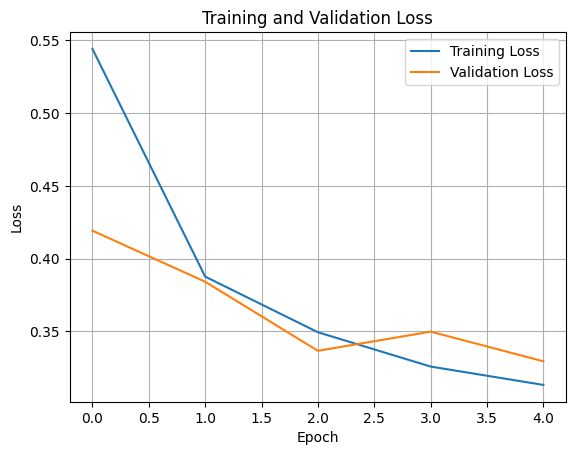

Overall Accuracy on the test set: 87.88%

Accuracy of T-shirt/top: 83.20%
Accuracy of    Trouser: 98.30%
Accuracy of   Pullover: 77.70%
Accuracy of      Dress: 78.10%
Accuracy of       Coat: 86.50%
Accuracy of     Sandal: 94.20%
Accuracy of      Shirt: 74.60%
Accuracy of    Sneaker: 95.50%
Accuracy of        Bag: 94.70%
Accuracy of Ankle boot: 96.00%


In [13]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Data Import, Preparation, and Preprocessing with Data Augmentation

# Define transformations for the training set (with data augmentation)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the data to [-1, 1]
])

# Define transformations for the test set (without data augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the data to [-1, 1]
])

# Download and load the training data with augmentation
trainset = torchvision.datasets.FashionMNIST(
    root='./data',        # Directory to store the dataset
    train=True,           # Specifies training set
    download=True,        # Downloads the dataset if not already present
    transform=train_transform   # Applies the transformations
)
trainloader = torch.utils.data.DataLoader(
    trainset,             # Dataset to load
    batch_size=64,        # Number of samples per batch
    shuffle=True          # Shuffle the data at every epoch
)

# Download and load the testing data (no augmentation)
testset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,          # Specifies test set
    download=True,
    transform=test_transform
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False         # No need to shuffle test data
)

# 2. Understanding the Data
# Map numeric labels to class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show one augmented image
print('Augmented Image:')
imshow(images[0])
print('Label:', classes[labels[0]])

# Get some random test images (without augmentation)
test_dataiter = iter(testloader)
test_images, test_labels = next(test_dataiter)

# Show one original test image
print('Original Test Image:')
imshow(test_images[0])
print('Label:', classes[test_labels[0]])

# 3. Visualizing Augmented Images

# Function to display a batch of images
def imshow_batch(img_batch, labels_batch, title):
    img_batch = img_batch / 2 + 0.5  # Unnormalize
    npimg = torchvision.utils.make_grid(img_batch, nrow=8)
    npimg = npimg.numpy()
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze())
    plt.title(title)
    plt.axis('off')
    plt.show()
    # Print labels
    print('Labels:', ' '.join(f'{classes[labels_batch[j]]}' for j in range(len(labels_batch))))

# Display a batch of augmented images
print('Batch of Augmented Images:')
imshow_batch(images[:32], labels[:32], 'Augmented Training Images')

# Display a batch of original test images
print('Batch of Original Test Images:')
imshow_batch(test_images[:32], test_labels[:32], 'Original Test Images')

# 4. Defining the Convolutional Neural Network with Dropout

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # [batch_size, 32, 14, 14]
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # [batch_size, 64, 7, 7]
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the network
net = CNNNet()

# 5. Choosing Loss Function and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

# 6. Training Parameters and Variables

num_epochs = 5
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 3  # Early stopping patience
trigger_times = 0

# 7. Training Loop with Early Stopping

for epoch in range(num_epochs):
    net.train()  # Set the model to training mode
    running_train_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()          # Zero the parameter gradients
        outputs = net(inputs)          # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights
        running_train_loss += loss.item()
    train_loss = running_train_loss / len(trainloader)
    train_losses.append(train_loss)

    net.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    val_loss = running_val_loss / len(testloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # Save the model checkpoint
        torch.save(net.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# 8. Loading the Best Model

net.load_state_dict(torch.load('best_model.pth'))

# 9. Plotting the Losses

plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 10. Evaluating the Final Model

def evaluate_network():
    net.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print(f'Overall Accuracy on the test set: {100 * correct / total:.2f}%\n')
    # Print accuracy for each class
    for i in range(10):
        if class_total[i] > 0:
            print(f'Accuracy of {classes[i]:>10s}: {100 * class_correct[i] / class_total[i]:.2f}%')
        else:
            print(f'Accuracy of {classes[i]:>10s}: N/A (no samples)')

# Call the evaluation function
evaluate_network()
